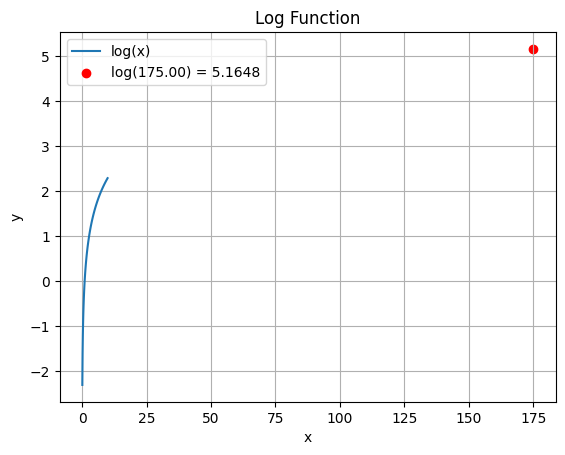

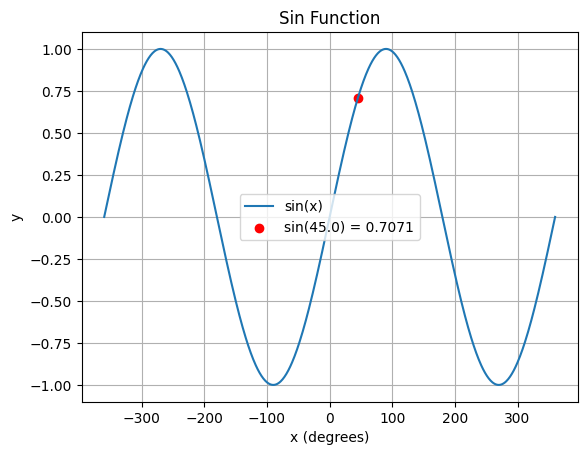

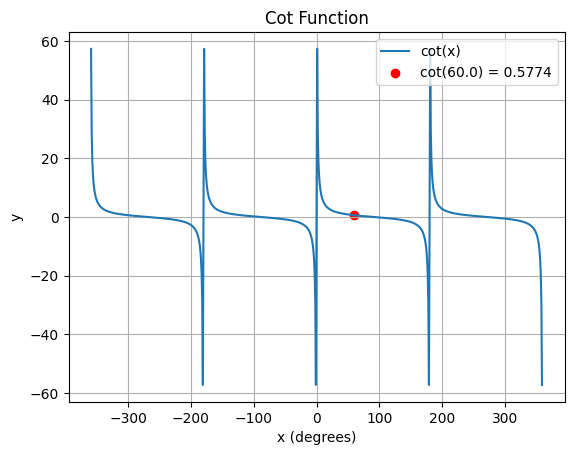

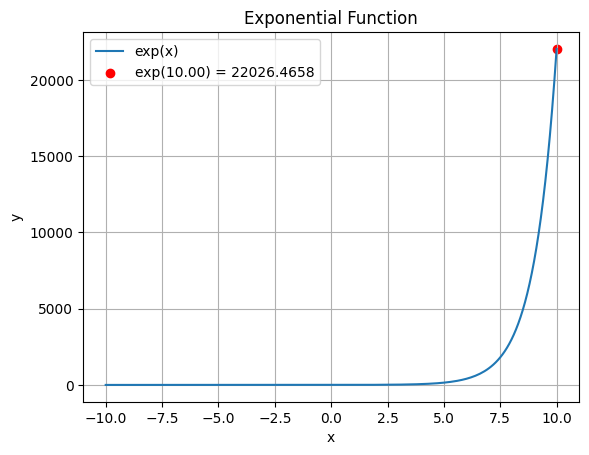

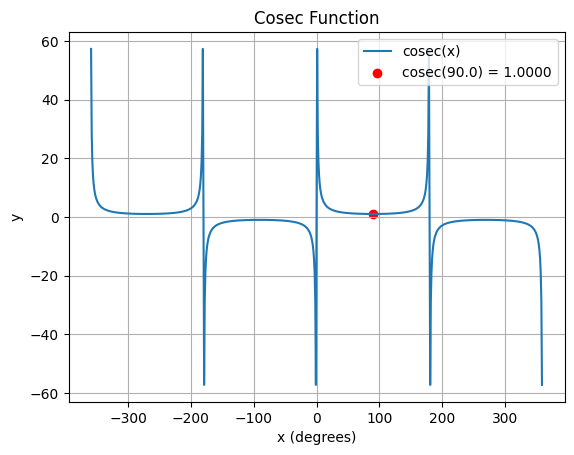

Result: 5.6342082287611e+128


In [1]:
import enum
import re
import math
import graphviz
import matplotlib.pyplot as plt  

class TokenType(enum.Enum):
    T_NUM = 0
    T_PLUS = 1
    T_MINUS = 2
    T_MULT = 3
    T_DIV = 4
    T_LPAR = 5
    T_RPAR = 6
    T_END = 7
    T_SIN = 8
    T_COS = 9
    T_TAN = 10
    T_LOG = 11
    T_VAR = 12
    T_SEC = 13
    T_COSEC = 14
    T_COT = 15
    T_POWER = 16
    T_SQRT = 17
    T_EXP = 18
    T_FACT = 19

class Node:
    def __init__(self, token_type, value=None):
        self.token_type = token_type
        self.value = value
        self.children = []

def lexical_analysis(s):
    mappings = {
        '+': TokenType.T_PLUS,
        '-': TokenType.T_MINUS,
        '*': TokenType.T_MULT,
        '/': TokenType.T_DIV,
        '(': TokenType.T_LPAR,
        ')': TokenType.T_RPAR,
        '^': TokenType.T_POWER,
    }

    function_mappings = {
        'sin': TokenType.T_SIN,
        'cos': TokenType.T_COS,
        'tan': TokenType.T_TAN,
        'log': TokenType.T_LOG,
        'sec': TokenType.T_SEC,
        'cosec': TokenType.T_COSEC,
        'cot': TokenType.T_COT,
        'sqrt': TokenType.T_SQRT,
        'exp': TokenType.T_EXP
    }

    tokens = []
    for token in re.findall(r'[+\-*/()^]|sqrt|\b(?:sin|cos|tan|log|sec|cosec|cot|exp)\b|\b[a-zA-Z_]\w*|\d+\.\d+|\d+|!', s):
        if token in mappings:
            token_type = mappings[token]
            tokens.append(Node(token_type, value=token))
        elif token in function_mappings:
            token_type = function_mappings[token]
            tokens.append(Node(token_type, value=token))
        elif re.match(r'\d+\.\d+|\d+', token):
            tokens.append(Node(TokenType.T_NUM, value=float(token)))
        elif re.match(r'\b[a-zA-Z_]\w*\b', token):
            tokens.append(Node(TokenType.T_VAR, value=token))
        elif token == '!':
            tokens.append(Node(TokenType.T_FACT))
        else:
            tokens.append(Node(TokenType.T_END, value="Invalid token: {}".format(token)))
            return tokens
    tokens.append(Node(TokenType.T_END))
    return tokens

def match(tokens, token):
    if tokens[0].token_type == token:
        return tokens.pop(0)
    else:
        raise ValueError('Invalid syntax on token {}'.format(tokens[0].token_type))

def parse_e(tokens):
    left_node = parse_e2(tokens)

    while tokens and tokens[0].token_type in [TokenType.T_PLUS, TokenType.T_MINUS]:
        node = tokens.pop(0)
        node.children.append(left_node)
        node.children.append(parse_e2(tokens))
        left_node = node

    return left_node

def parse(inputstring):
    try:
        tokens = lexical_analysis(inputstring)
        ast = parse_e(tokens)

        # Check if there are no more tokens left after parsing the expression
        if tokens and tokens[0].token_type != TokenType.T_END:
            raise ValueError('Invalid syntax. Expected end of input.')

        return ast
    except ValueError as e:
        print(e)
        return None

def parse_e2(tokens):
    left_node = parse_e3(tokens)

    while tokens and tokens[0].token_type in [TokenType.T_MULT, TokenType.T_DIV]:
        node = tokens.pop(0)
        node.children.append(left_node)
        node.children.append(parse_e3(tokens))
        left_node = node

    return left_node

def parse_e3(tokens):
    if tokens[0].token_type == TokenType.T_NUM:
        return tokens.pop(0)

    if tokens[0].token_type == TokenType.T_VAR:
        return tokens.pop(0)

    if tokens[0].token_type in [TokenType.T_SIN, TokenType.T_COS, TokenType.T_TAN, TokenType.T_LOG, TokenType.T_SEC, TokenType.T_COSEC, TokenType.T_COT, TokenType.T_SQRT, TokenType.T_EXP]:
        func_node = tokens.pop(0)
        match(tokens, TokenType.T_LPAR)
        func_node.children.append(parse_e(tokens))
        match(tokens, TokenType.T_RPAR)
        return func_node

    # Factorial has the highest precedence, so we handle it after primary expressions
    primary_node = parse_primary(tokens)
    while tokens and tokens[0].token_type == TokenType.T_FACT:
        fact_node = tokens.pop(0)
        fact_node.children.append(primary_node)
        primary_node = fact_node

    return primary_node

def parse_primary(tokens):
    if tokens[0].token_type == TokenType.T_NUM:
        return tokens.pop(0)

    if tokens[0].token_type == TokenType.T_VAR:
        return tokens.pop(0)

    if tokens[0].token_type == TokenType.T_LPAR:
        tokens.pop(0)
        expression = parse_e(tokens)
        match(tokens, TokenType.T_RPAR)
        return expression

    raise ValueError("Invalid syntax on token {}".format(tokens[0].token_type))

def evaluate_ast(node, variables=None):
    if node.token_type == TokenType.T_NUM:
        return node.value
    elif node.token_type == TokenType.T_PLUS:
        return evaluate_ast(node.children[0], variables) + evaluate_ast(node.children[1], variables)
    elif node.token_type == TokenType.T_MINUS:
        return evaluate_ast(node.children[0], variables) - evaluate_ast(node.children[1], variables)
    elif node.token_type == TokenType.T_MULT:
        return evaluate_ast(node.children[0], variables) * evaluate_ast(node.children[1], variables)
    elif node.token_type == TokenType.T_DIV:
        divisor = evaluate_ast(node.children[1], variables)
        if divisor == 0:
            raise ValueError("Math domain error: division by zero")
        return evaluate_ast(node.children[0], variables) / divisor
    elif node.token_type == TokenType.T_SIN:
        angle = evaluate_ast(node.children[0], variables)
        result = math.sin(math.radians(angle))
        # Plot the sin function graph
        x = [i for i in range(-360, 361)]
        y = [math.sin(math.radians(i)) for i in range(-360, 361)]
        plt.plot(x, y, label='sin(x)')
        plt.scatter(angle, result, color='red', label='sin({}) = {:.4f}'.format(angle, result))
        plt.xlabel('x (degrees)')
        plt.ylabel('y')
        plt.title('Sin Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_COS:
        angle = evaluate_ast(node.children[0], variables)
        result = math.cos(math.radians(angle))
        # Plot the cos function graph
        x = [i for i in range(-360, 361)]
        y = [math.cos(math.radians(i)) for i in range(-360, 361)]
        plt.plot(x, y, label='cos(x)')
        plt.scatter(angle, result, color='red', label='cos({}) = {:.4f}'.format(angle, result))
        plt.xlabel('x (degrees)')
        plt.ylabel('y')
        plt.title('Cos Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_TAN:
        angle = evaluate_ast(node.children[0], variables)
        result = math.tan(math.radians(angle))
        # Plot the tan function graph
        x = [i for i in range(-360, 361)]
        y = [math.tan(math.radians(i)) for i in range(-360, 361)]
        plt.plot(x, y, label='tan(x)')
        plt.scatter(angle, result, color='red', label='tan({}) = {:.4f}'.format(angle, result))
        plt.xlabel('x (degrees)')
        plt.ylabel('y')
        plt.title('Tan Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_LOG:
        val = evaluate_ast(node.children[0], variables)
        if val <= 0:
            raise ValueError("Math domain error: log(x) is undefined for x <= 0")
        result = math.log(val)
        # Plot the log function graph
        x = [i / 10 for i in range(1, 100)]
        y = [math.log(i) for i in x]
        plt.plot(x, y, label='log(x)')
        plt.scatter(val, result, color='red', label='log({:.2f}) = {:.4f}'.format(val, result))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Log Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_SEC:
        angle = evaluate_ast(node.children[0], variables)
        result = 1 / math.cos(math.radians(angle))
        # Plot the sec function graph
        x = [i for i in range(-360, 361)]
        y = [1 / math.cos(math.radians(i)) for i in range(-360, 361)]
        plt.plot(x, y, label='sec(x)')
        plt.scatter(angle, result, color='red', label='sec({}) = {:.4f}'.format(angle, result))
        plt.xlabel('x (degrees)')
        plt.ylabel('y')
        plt.title('Sec Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_COSEC:
        angle = evaluate_ast(node.children[0], variables)
        if angle % 180 == 0:
            raise ValueError("Math domain error: cosec({}) is undefined".format(angle))
        result = 1 / math.sin(math.radians(angle))
        # Plot the cosec function graph
        x = [i for i in range(-360, 361) if i % 180 != 0]  # Exclude angles causing division by zero
        y = [1 / math.sin(math.radians(i)) for i in x]
        plt.plot(x, y, label='cosec(x)')
        plt.scatter(angle, result, color='red', label='cosec({}) = {:.4f}'.format(angle, result))
        plt.xlabel('x (degrees)')
        plt.ylabel('y')
        plt.title('Cosec Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_COT:
        angle = evaluate_ast(node.children[0], variables)
        result = 1 / math.tan(math.radians(angle))
        # Plot the cot function graph, excluding points where tan(i) is close to zero
        x = [i for i in range(-360, 361) if abs(math.tan(math.radians(i))) > 1e-9]
        y = [1 / math.tan(math.radians(i)) for i in x]
        plt.plot(x, y, label='cot(x)')
        plt.scatter(angle, result, color='red', label='cot({}) = {:.4f}'.format(angle, result))
        plt.xlabel('x (degrees)')
        plt.ylabel('y')
        plt.title('Cot Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_SQRT:
        val = evaluate_ast(node.children[0], variables)
        result = math.sqrt(val)
        # Plot the square root function graph
        x = [i / 10 for i in range(1, 100)]
        y = [math.sqrt(i) for i in x]
        plt.plot(x, y, label='sqrt(x)')
        plt.scatter(val, result, color='red', label='sqrt({:.2f}) = {:.4f}'.format(val, result))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Square Root Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_EXP:
        val = evaluate_ast(node.children[0], variables)
        result = math.exp(val)
        # Plot the exponential function graph
        x = [i / 10 for i in range(-100, 101)]
        y = [math.exp(i) for i in x]
        plt.plot(x, y, label='exp(x)')
        plt.scatter(val, result, color='red', label='exp({:.2f}) = {:.4f}'.format(val, result))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Exponential Function')
        plt.legend()
        plt.grid(True)
        plt.show()
        return result
    elif node.token_type == TokenType.T_FACT:
        num = evaluate_ast(node.children[0], variables)
        if num < 0:
            raise ValueError("Math domain error: factorial is not defined for negative numbers")
        result = math.factorial(int(num))
        return result
    elif node.token_type == TokenType.T_VAR:
        if variables is not None and node.value in variables:
            return variables[node.value]
        else:
            return float(input(f"Enter value for variable '{node.value}': "))

def visualize_ast(node, graph=None, node_color='lightblue', edge_color='black', font_color='black'):
    if graph is None:
        graph = graphviz.Digraph(comment='Abstract Syntax Tree')

    label = str(node.value) if node.token_type in [TokenType.T_NUM, TokenType.T_VAR, TokenType.T_FACT] else str(node.value)
    graph.node(label, style='filled', fillcolor=node_color, fontcolor=font_color)

    for child in node.children:
        child_label = str(child.value) if child.token_type in [TokenType.T_NUM, TokenType.T_VAR, TokenType.T_FACT] else str(child.value)
        graph.node(child_label, style='filled', fillcolor=node_color, fontcolor=font_color)
        graph.edge(label, child_label, color=edge_color)
        visualize_ast(child, graph, node_color=node_color, edge_color=edge_color, font_color=font_color)

    return graph

def get_input_expression():
    input_expr = input("Enter a mathematical expression: ")
    return input_expr

if __name__ == "__main__":
    input_expr = get_input_expression()
    ast = parse(input_expr)

    if ast is not None:
        try:
            # Get variable values from the user
            variable_values = {}
            for node in ast.children:
                if node.token_type == TokenType.T_VAR:
                    variable_values[node.value] = float(input(f"Enter value for variable '{node.value}': "))

            # Evaluate the AST and print the result
            result = evaluate_ast(ast, variable_values)
            print("Result:", result)

            # Create a graph and visualize the AST with the result
            node_color = 'lightblue'
            edge_color = 'black'
            font_color = 'black'
            dot = visualize_ast(ast, node_color=node_color, edge_color=edge_color, font_color=font_color)
            dot.node('Result', str(result), style='filled', fillcolor='lightgreen', fontcolor='black')
            dot.edge('Result', str(ast.value), label='Result', color='blue')
            dot.format = 'png'
            dot.render('ast', view=True)
        except ValueError as e:
            print(e)
